In [1]:
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
from gsw import sigma0
import numpy.ma as ma

import time
import yaml

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '/home1/datahome/mlejeune/cartopy_shapefiles'



In [ ]:
d_test = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/test_ds.nc")
d_train = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/train_ds.nc")

In [2]:
d_test

NameError: name 'd_test' is not defined

##  Adding attributes 

In [3]:
def add_attributs(value): 
    value['PSAL_predicted'].attrs['standard_name'] = "predicted salinity"
    value['PSAL_predicted'].attrs['long_name'] = "predicted salinity"
    value['PSAL_predicted'].attrs['units'] = "Pa"

    value['TEMP_predicted'].attrs['standard_name'] = "predicted temperature"
    value['TEMP_predicted'].attrs['long_name'] = "predicted temperature"
    value['TEMP_predicted'].attrs['units'] = "Kelvin"

    value['PSAL_predicted_std'].attrs['standard_name'] = "predicted salinity with uncertainty"
    value['PSAL_predicted_std'].attrs['long_name'] = "predicted salinity with uncertainty"
    value['PSAL_predicted_std'].attrs['units'] = "Pa"

    value['TEMP_predicted_std'].attrs['standard_name'] = "predicted temperature with uncertainty"
    value['TEMP_predicted_std'].attrs['long_name'] = "predicted temperature with uncertainty"
    value['TEMP_predicted_std'].attrs['units'] = "Kelvin"

    value['ae_S'].attrs['standard_name'] = "absolute salinity error "
    value['ae_T'].attrs['standard_name'] = "absolute salinity error "

    value['rmse_T_model'].attrs['standard_name'] = "root mean square error"
    value['rmse_S_model'].attrs['standard_name'] = "root mean square error"

    value['MLD'].attrs['standard_name'] = "Surface Mixed Layer Depth"
    value['MLD_pred'].attrs['standard_name'] = "Surface Mixed Layer Depth predicted"
    value['MLD'].attrs['untis'] = "m"
    value['MLD_pred'].attrs['untis'] = "m"

    value['dayOfYear'].attrs['standard_name'] = "Day of the year"

    value['SIG_predicted'].attrs['standard_name'] = "sea_water_sigma_t predicted"
    value['SIG_predicted'].attrs['units'] = "kg/m^3"

    value['SIG'].attrs['standard_name'] = "sea_water_sigma_t"
    value['SIG'].attrs['units'] = "kg/m^3"

    value['CT'].attrs['standard_name'] = "sea_water_conservative_temperature"
    value['CT'].attrs['units'] = "Kelvin"

    value['SA'].attrs['standard_name'] = "sea_water_absolute_salinity"
    value['SA'].attrs['units'] = "g / kg"


add_attributs(d_test)
add_attributs(d_train)


## Comparison with real profiles

[Text(0, 0.5, 'Profondeur'), Text(0, 0.5, 'Profondeur')]

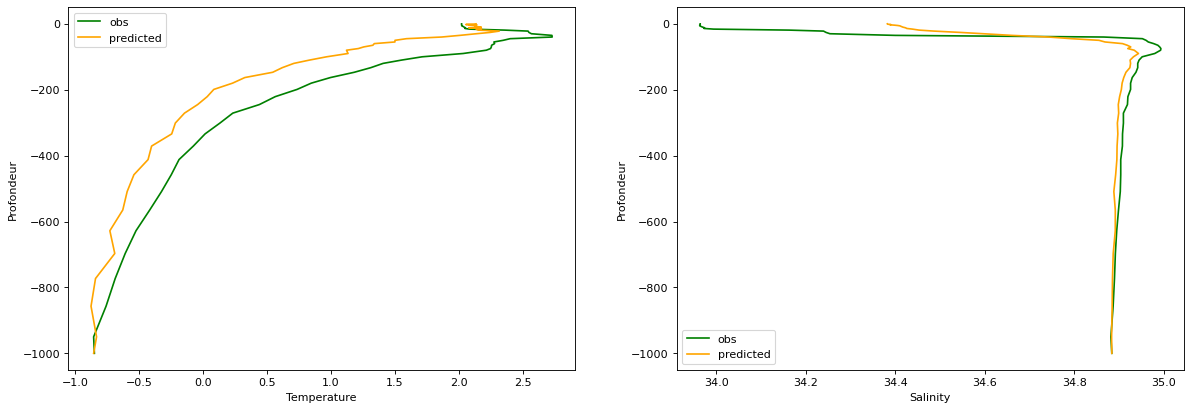

In [6]:
n = 5
dss = d_test.isel(N_PROF=n)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

ax[0].plot(dss['TEMP'], -dss['DEPTH'], label='obs',c = 'green')
ax[0].plot(dss['TEMP_predicted'], -dss['DEPTH'], label='predicted',c = 'orange')

ax[1].plot(dss['PSAL'], -dss['DEPTH'], label='obs',c = 'green')
ax[1].plot(dss['PSAL_predicted'], -dss['DEPTH'], label='predicted',c = 'orange')

leg = ax[0].legend();
leg = ax[1].legend();

plt.setp(ax[0], xlabel='Temperature')
plt.setp(ax[1], xlabel='Salinity')


plt.setp(ax[0 : 2], ylabel='Profondeur')

## RMSE

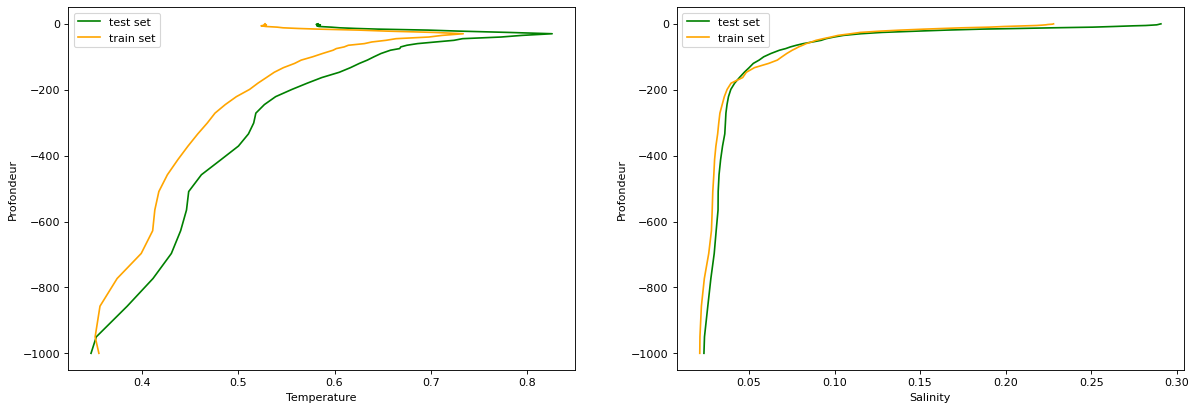

In [7]:
n = 10
dss = d_test.isel(N_PROF=n)
dss_2 = d_train.isel(N_PROF=n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=80, facecolor='w', edgecolor='k')


ax[0].plot(dss['rmse_T_model'][0], -dss['DEPTH'], label='test set',c = 'green')
ax[0].plot(dss_2['rmse_T_model'][0], -dss['DEPTH'], label='train set',c = 'orange')


ax[1].plot(dss['rmse_S_model'][0], -dss['DEPTH'], label='test set',c = 'green')
ax[1].plot(dss_2['rmse_S_model'][0], -dss['DEPTH'], label='train set',c = 'orange')

plt.setp(ax[0], xlabel='Temperature')
plt.setp(ax[1], xlabel='Salinity')

plt.setp(ax[0 : 2], ylabel='Profondeur')

leg = ax[0].legend();
leg = ax[1].legend();

## Error map

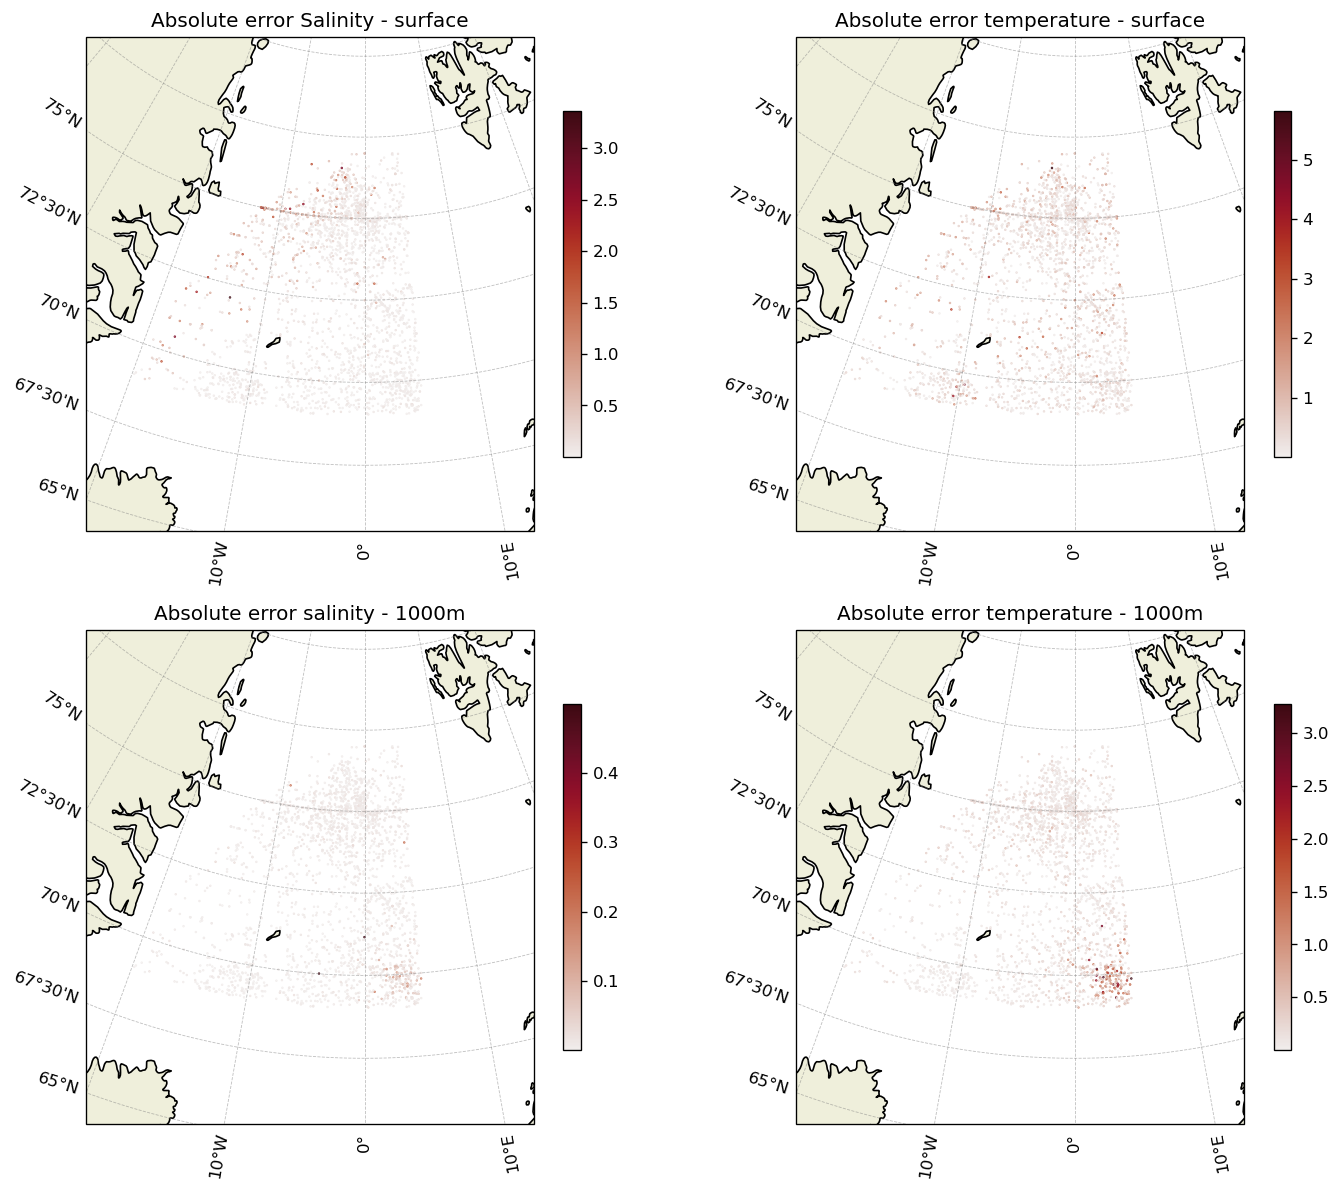

In [10]:
proj=ccrs.NorthPolarStereo()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([12, -20, 65, 80])
subplot_kw = {'projection': proj, 'extent': extent}

ds = d_test.isel(DEPTH=0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
te = ax[0,0].scatter(ds.LONGITUDE,ds.LATITUDE,c = ds.ae_S,transform=ccrs.PlateCarree(), s = .2,cmap =  cmocean.cm.amp)
cbar = plt.colorbar(te, ax=ax[0,0], shrink=0.7)
ax[0,0].set_title('Absolute error Salinity - surface')

te = ax[0,1].scatter(ds.LONGITUDE,ds.LATITUDE,c = ds.ae_T,transform=ccrs.PlateCarree(), s = .2,cmap =  cmocean.cm.amp)
cbar = plt.colorbar(te, ax=ax[0,1], shrink=0.7)
ax[0,1].set_title('Absolute error temperature - surface')

ds = d_test.isel(DEPTH=50)

te = ax[1,0].scatter(ds.LONGITUDE,ds.LATITUDE,c = ds.ae_S,transform=ccrs.PlateCarree(), s = .2,cmap =  cmocean.cm.amp)
cbar = plt.colorbar(te, ax=ax[1,0], shrink=0.7)
ax[1,0].set_title('Absolute error salinity - 1000m')

te = ax[1,1].scatter(ds.LONGITUDE,ds.LATITUDE,c = ds.ae_T,transform=ccrs.PlateCarree(), s = .2,cmap =  cmocean.cm.amp)
cbar = plt.colorbar(te, ax=ax[1,1], shrink=0.7)
ax[1,1].set_title('Absolute error temperature - 1000m')

for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
